In [1]:
from skimage import io

original_image = io.imread("CT_ScoutView.jpg")

width=90
detector_amount=360
alpha=2

In [2]:
# Algorytm Bresenhama
def bresenham_line(x0, y0, x1, y1):
    line = []
    kx = 1 if x0 <= x1 else -1
    ky = 1 if y0 <= y1 else -1

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    x = x0
    y = y0
    line.append([x, y])
    if dx >= dy:
        e = dx / 2
        for i in range(0, int(dx)):
            x = x + kx
            e = e - dy
            if e < 0:
                y = y + ky
                e = e + dx
            line.append([x, y])
    else:
        e = dy / 2
        for i in range(0, int(dy)):
            y = y + ky
            e = e - dx
            if e < 0:
                x = x + kx
                e = e + dy
            line.append([x, y])
    return line

In [3]:
import numpy as np


# Transformata Radona
#def picture2sinogram(picture, width=90, detector_amount=360, alpha=2):
def picture2sinogram(picture, width, detector_amount, alpha):
    centre_of_image = [int(picture.shape[1]/2), int(picture.shape[0]/2)] 
    r = min(centre_of_image[0], centre_of_image[1])
    print(centre_of_image)

    sinogram = []
    lines = []

    # poruszaj emiterem 360/n razy o kąt alpha i zbierz próbki promieni.
    for i in range(0, 360, alpha):
        sinogram.append([])
        lines.append([])
        for detector in range(0, detector_amount):
            x0 = r * np.cos(i * np.pi / 180)
            y0 = r * np.sin(i * np.pi / 180)

            x1 = r * np.cos((i + 180 - (width / 2) + detector * (width / (detector_amount - 1))) * np.pi / 180)
            y1 = r * np.sin((i + 180 - (width / 2) + detector * (width / (detector_amount - 1))) * np.pi / 180)

            x0 = int(x0) + np.floor(centre_of_image[1])
            x1 = int(x1) + np.floor(centre_of_image[1])
            y0 = int(y0) + np.floor(centre_of_image[0])
            y1 = int(y1) + np.floor(centre_of_image[0])

            line = bresenham_line(x0, y0, x1, y1)

            pixel = change_brightness(picture, line)


            sinogram[-1].append(pixel)
            lines[-1].append([x0, y0, x1, y1])


    
    return sinogram, lines


def change_brightness(picture, line):
    raw = 0
    pixel_max = 0
    for pos in line:
        if 0 <= pos[0] < len(picture) and 0 <= pos[1] < len(picture):
            raw += picture[min(int(pos[0]), picture.shape[0]-1), min(int(pos[1]), picture.shape[1]-1)]
            pixel_max += 1
    assert pixel_max != 0
    normalized = raw / pixel_max
    return normalized

In [4]:
from skimage.exposure import rescale_intensity
from skimage.metrics import mean_squared_error
import scipy.signal as sig

import math
import imageio

# def filtering_picture(img):
#     new = filters.gaussian_filter(img, sigma=1)
#     # new = rescale_intensity(new)
#     new = mp.dilation(mp.erosion(new))
#     return new

def filtering_sinogram(sinogram):
    sinogram_shape = np.shape(sinogram)
    number_of_projections = sinogram_shape[0]
    number_of_detectors = sinogram_shape[1]

    filtered = np.zeros((number_of_projections, number_of_detectors))
    mask = do_mask(number_of_detectors)

    # splot każdej projekcji z naszą maską
    for projection in range(0, number_of_projections, 1):
        filtered[projection] = sig.convolve(sinogram[projection], mask, mode='same', method='direct')

    return filtered


def do_mask(detectors):
    # maska jednowymiarowa
    mask_size = math.floor(detectors / 2)
    mask = np.zeros(mask_size)
    center = math.floor(mask_size / 2)
    for i in range(0, mask_size, 1):
        k = i - center
        if k % 2 != 0:
            mask[i] = (-4 / np.pi ** 2) / k ** 2
    mask[center] = 1
    return mask

def normalize(reconstructed_, helper):
    normalized = np.copy(reconstructed_)
    picture_shape = np.shape(normalized)
    width = picture_shape[0]
    height = picture_shape[1]
    for i in range(0, width, 1):
        for j in range(0, height, 1):
            if helper[i][j] != 0:
                normalized[i][j] = normalized[i][j] / helper[i][j]
    return normalized

def gamma(img, gamma_):
    new = img ** gamma_
    return new

# Projekcja wsteczna
def back_projection(picture, sinogram, lines, filtr):
    projection = []
    if filtr:
        sinogram = filtering_sinogram(sinogram)
    
    # wymiary zdjęcia końcowego
    picture_shape = np.shape(picture)
    width = picture_shape[0]
    height = picture_shape[1]
    

    # dane o projekcjach i detektorach
    sinogram_shape = np.shape(sinogram)
    number_of_projections = sinogram_shape[0]
    number_of_detectors = sinogram_shape[1]

    # dane do tworzenia gifa i statystyk
    images = []
    iterator = 0
    # dane do rekonstrukcji zdjęcia
    reconstructed_ = np.zeros(shape=picture_shape)
    helper = np.zeros(shape=picture_shape)

    # rekonstrukcja zdjęcia
    for projection in range(0, number_of_projections, 1):
        for detector in range(0, number_of_detectors, 1):
            x0, y0, x1, y1 = lines[projection][detector]
            line = bresenham_line(x0, y0, x1, y1)
            value = sinogram[projection][detector]
            for i in range(0, len(line), 1):
                x, y = line[i]
                if 0 <= x < width and 0 <= y < height:
                    reconstructed_[int(x)][int(y)] += value
                    helper[int(x)][int(y)] += 1
        images.append(reconstructed_.copy())


    
    return reconstructed_, images

In [5]:
from ipywidgets import interact
import ipywidgets as widgets


def use_alfa(x):
    global alpha
    alpha = int(x)

def use_detectors(x):
    global detector_amount
    detector_amount = x

def use_range_pi(x):
    global width
    width = x


interact(use_alfa, x = widgets.FloatSlider(description='alpha:', min=2,max=360 , step=2,value=alpha))
interact(use_detectors, x = widgets.IntSlider(description= 'detector_amount:', min=10,max  = 500, step=10, value=detector_amount))
interact(use_range_pi, x = widgets.IntSlider(description= 'width:', min=0 , max= 360, step=10, value=width))


interactive(children=(FloatSlider(value=2.0, description='alpha:', max=360.0, min=2.0, step=2.0), Output()), _…

interactive(children=(IntSlider(value=360, description='detector_amount:', max=500, min=10, step=10), Output()…

interactive(children=(IntSlider(value=90, description='width:', max=360, step=10), Output()), _dom_classes=('w…

<function __main__.use_range_pi(x)>

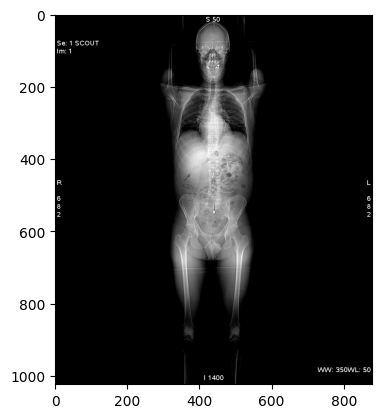

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

plt.imshow(original_image, cmap='gray')

[440, 512]


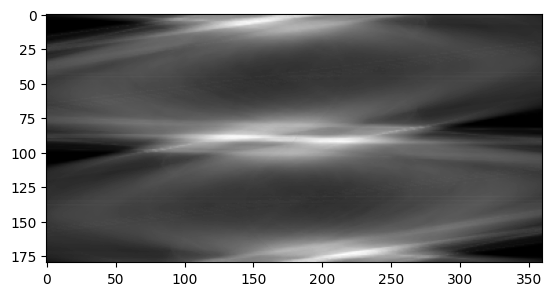

In [7]:

sinogram, lines = picture2sinogram(original_image, width, detector_amount, alpha)
plt.imshow(sinogram, cmap='gray')

plt.show()


# fig, plots = plt.subplots(1, 2)
# plots[0].imshow(original_image, cmap='gray')
# plots[1].imshow(reconstructed, cmap='gray')
# plt.show()

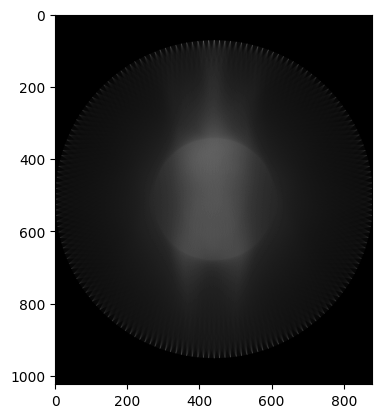

In [8]:
reconstructed, projection = back_projection(original_image, sinogram, lines, False)
plt.imshow(reconstructed, cmap='gray')
plt.show()

In [9]:
reconstructed.max()

28993.569179236692

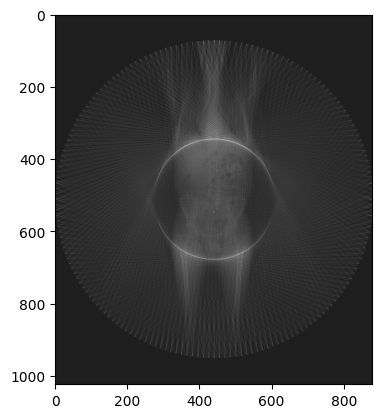

In [10]:
reconstructed, projection = back_projection(original_image, sinogram, lines, True)
plt.imshow(reconstructed, cmap='gray')
plt.show()

## Iteracyjna prezentacja

In [11]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed

def display_images(images, index):
    plt.clf()
    
    plt.imshow(images[index], cmap='gray')
    plt.title(f"Etapy rekonstrukcji: Krok {index+1}")
    plt.axis('off')  
    plt.show()


def interactive_display(images):
    interact(display_images, images=fixed(images), index=IntSlider(min=0, max=len(images)-1, step=1, value=0, description='Krok rekonstrukcji'))

interactive_display(projection)


interactive(children=(IntSlider(value=0, description='Krok rekonstrukcji', max=179), Output()), _dom_classes=(…

## Dicom


In [12]:
import pydicom
import pydicom._storage_sopclass_uids

def create_dicom(name_patient, date_patient, commentary_patient):
    global reconstructed  
    photo_dcm = (reconstructed).astype(np.uint16)

    meta = pydicom.Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    Data = pydicom.Dataset()
    Data.file_meta = meta
    Data.is_little_endian = True
    Data.is_implicit_VR = False
    Data.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
    Data.PatientName = name_patient
    Data.StudyDate = date_patient
    Data.StudyDescription = commentary_patient
    Data.Modality = "MR"
    Data.SeriesInstanceUID = pydicom.uid.generate_uid()
    Data.StudyInstanceUID = pydicom.uid.generate_uid()
    Data.FrameOfReferenceUID = pydicom.uid.generate_uid()

    Data.BitsAllocated = 16
    Data.BitsStored = 16
    Data.HighBit = 15
    Data.SamplesPerPixel = 1
    Data.ImagesInAcquisition = "1" 
    Data.Rows = photo_dcm.shape[0]
    Data.Columns = photo_dcm.shape[1]

    Data.ImagePositionPatient = r"0\0\1"
    Data.ImageOrientationPatient = r"1\0\0\0\-1\0"
    Data.ImageType = r"ORIGINAL\PRIMARY\AXIAL"
    Data.RescaleIntercept = "0"
    Data.RescaleSlope = "1"
    Data.PixelSpacing = r"1\1"
    Data.PhotometricInterpretation = "MONOCHROME2"
    Data.PixelRepresentation = 1

    pydicom.dataset.validate_file_meta(Data.file_meta, enforce_standard=True)
    Data.PixelData = photo_dcm.tobytes()
    Data.save_as("DICOM.dcm")




In [13]:
# Możliwość wpisania danych do pliku DICOM w Jupyterze

name = widgets.Text(description="Imię:")
date = widgets.Text(description="Data (DD/MM/YYYY):")
comment = widgets.Textarea(description="Komentarz:")

button = widgets.Button(description="Zapisz do DICOM")
button.on_click(lambda x: create_dicom(name.value, date.value, comment.value))
display(name, date, comment, button)

Text(value='', description='Imię:')

Text(value='', description='Data (DD/MM/YYYY):')

Textarea(value='', description='Komentarz:')

Button(description='Zapisz do DICOM', style=ButtonStyle())

Informacje
Imie i nazwisko:  ABC
Data:  13/04/2024
Komentarz:  Proba


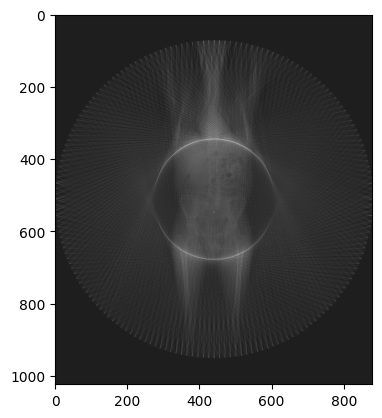

In [14]:
def open_dicom(name_dcm, name_patient,date_patient,commentary_patient):
    information = pydicom.dcmread(name_dcm, force=True)
    name_patient = information.PatientName
    date_patient = information.StudyDate
    commentary_patient = information.StudyDescription
    print("Informacje")
    print("Imie i nazwisko: ", name_patient)
    print("Data: ", date_patient)
    print("Komentarz: ", commentary_patient)
    plt.imshow(information.pixel_array,cmap="gray")


open_dicom("DICOM.dcm", name, date, comment)

In [15]:
def scale_brightness(image1):
    return rescale_intensity(image1, out_range=(0, 1))
    


In [16]:
# Eksperyment proszę przeprowadzić na tym samym obrazie (nie może być to jednak obraz trywialny typu kółko lub dwa kwadraty). Proszę rozważyć jego następujące warianty (parametry, które nie są modyfikowane, powinny mieć wartości domyślne): liczba detektorów zmienia się od 90 do 720 z krokiem 90,
result = []
original_image = scale_brightness(original_image)
for i in range(90, 721, 90):
    sinogram, lines = picture2sinogram(original_image, width, i, alpha)
    reconstructed, _ = back_projection(original_image, sinogram, lines, False)
    scale_brightness(reconstructed)
    result.append([i, math.sqrt(mean_squared_error(original_image, reconstructed))])
    print(f"Mean squared error dla {i} detektorów: {result[-1]}")


[440, 512]
Mean squared error dla 90 detektorów: [90, 3.2902445808627245]
[440, 512]
Mean squared error dla 180 detektorów: [180, 6.685937914220276]
[440, 512]
Mean squared error dla 270 detektorów: [270, 10.088360176093747]
[440, 512]
Mean squared error dla 360 detektorów: [360, 13.494372974090599]
[440, 512]
Mean squared error dla 450 detektorów: [450, 16.905096304050744]
[440, 512]
Mean squared error dla 540 detektorów: [540, 20.31422187497671]
[440, 512]
Mean squared error dla 630 detektorów: [630, 23.72364796958374]
[440, 512]
Mean squared error dla 720 detektorów: [720, 27.137463024733357]


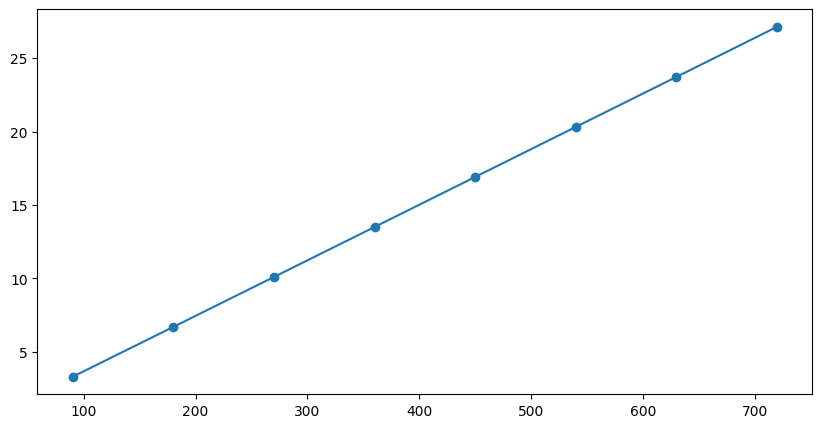

In [17]:
plt.figure(figsize=(10, 5))
plt.scatter([x[0] for x in result], [x[1] for x in result])
plt.plot([x[0] for x in result], [x[1] for x in result])

In [18]:
# Eksperyment proszę przeprowadzić na tym samym obrazie (nie może być to jednak obraz trywialny typu kółko lub dwa kwadraty). Proszę rozważyć jego następujące warianty (parametry, które nie są modyfikowane, powinny mieć wartości domyślne): rozpiętość wachlarza zmienia się od 45 do 270 stopni z krokiem 45 stopni.

result_2 = []

for i in range(45, 271, 45):
    sinogram, lines = picture2sinogram(original_image, width, detector_amount, i)
    reconstructed, _ = back_projection(original_image, sinogram, lines, False)
    reconstructed = scale_brightness(reconstructed)
    
    result_2.append([i, math.sqrt(mean_squared_error(original_image, reconstructed))])
    print(f"Mean squared error dla {i} stopni: {result_2[-1]}")
    


[440, 512]
Mean squared error dla 45 stopni: [45, 0.1979544226967584]
[440, 512]
Mean squared error dla 90 stopni: [90, 0.19936023305691342]
[440, 512]
Mean squared error dla 135 stopni: [135, 0.2004516283750819]
[440, 512]
Mean squared error dla 180 stopni: [180, 0.19997620110549072]
[440, 512]
Mean squared error dla 225 stopni: [225, 0.20087822999058855]
[440, 512]
Mean squared error dla 270 stopni: [270, 0.20089770109071414]


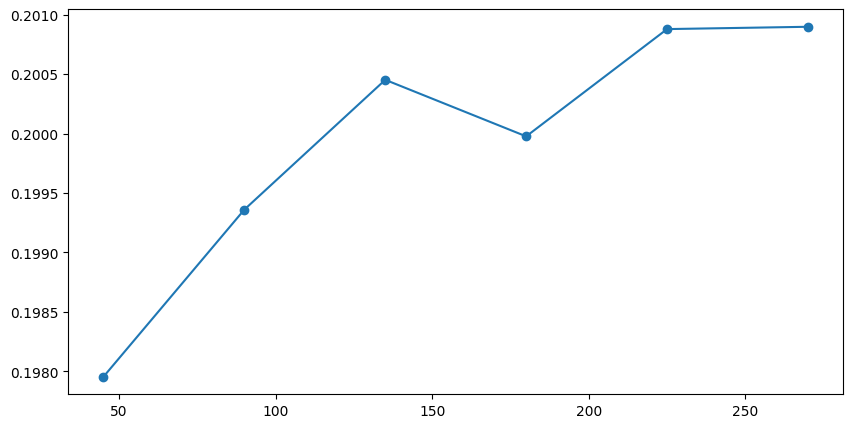

In [19]:
plt.figure(figsize=(10, 5))
plt.scatter([x[0] for x in result_2], [x[1] for x in result_2])
plt.plot([x[0] for x in result_2], [x[1] for x in result_2])

In [24]:
# Eksperyment proszę przeprowadzić na tym samym obrazie (nie może być to jednak obraz trywialny typu kółko lub dwa kwadraty). Proszę rozważyć jego następujące warianty (parametry, które nie są modyfikowane, powinny mieć wartości domyślne): liczba skanów (nie detektorów!) zmienia się od 90 do 720 z krokiem 90,

result_3 = []
alpha=2

for i in range(90, 721, 90):
    #alpha = 180 / i  # Degrees per scan
    #wid = alpha * math.pi / 180  # Convert alpha to radians

    sinogram, lines = picture2sinogram(original_image, i, detector_amount, alpha)
    reconstructed, _ = back_projection(original_image, sinogram, lines, False)
    reconstructed = scale_brightness(reconstructed)
    result_3.append([i, math.sqrt(mean_squared_error(original_image, reconstructed))])
    print(f"Mean squared error for {i} scans: {result_3[-1]}")

[440, 512]
Mean squared error for 90 scans: [90, 0.14106738460358295]
[440, 512]
Mean squared error for 180 scans: [180, 0.14808077689788496]
[440, 512]
Mean squared error for 270 scans: [270, 0.15324820236520756]
[440, 512]
Mean squared error for 360 scans: [360, 0.16977515595337347]
[440, 512]
Mean squared error for 450 scans: [450, 0.17715636550246153]
[440, 512]
Mean squared error for 540 scans: [540, 0.17784981026479948]
[440, 512]
Mean squared error for 630 scans: [630, 0.17783909656202215]
[440, 512]
Mean squared error for 720 scans: [720, 0.1703853579995522]


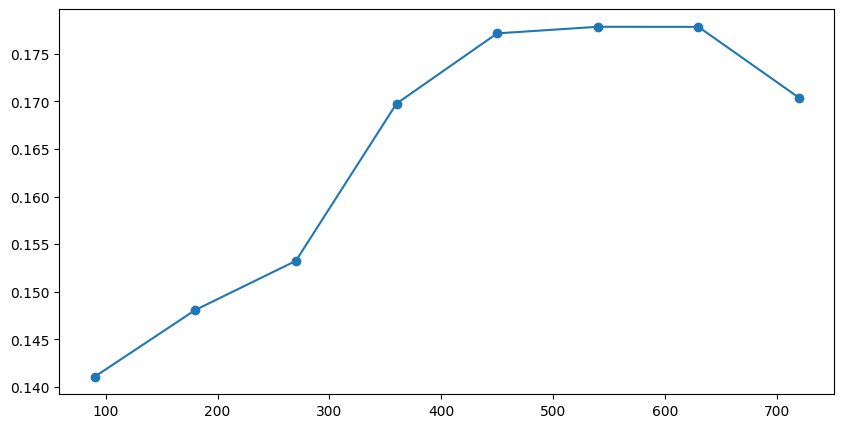

In [25]:
plt.figure(figsize=(10, 5))
plt.scatter([x[0] for x in result_3], [x[1] for x in result_3])
plt.plot([x[0] for x in result_3], [x[1] for x in result_3])

In [26]:
# Dla dwóch wybranych obrazów oraz następujących parametrów: liczba detektorów = 360, liczba skanów = 360, rozpiętość wachlarza = 270 stopni, proszę wykonać dwa warianty obliczeń -- z włączonym i wyłączonym filtrowaniem sinogramu. Dla każdego obrazu proszę zaprezentować RMSE dla obrazu bez filtrowania i z filtrowaniem oraz krótko skomentować różnice w jakości między obrazami.

# bez filtrowania
sinogram_without_filter, lines_without_filter = picture2sinogram(original_image, width, detector_amount, alpha)
constr_without_filter, _ = back_projection(original_image, sinogram_without_filter, lines_without_filter, False)
scale_brightness(constr_without_filter)
print(f"Mean squared error dla obrazu bez filtrowania: {math.sqrt(mean_squared_error(original_image, constr_without_filter))}")


# z filtrowaniem
sinogram_with_filter, lines_with_filter = picture2sinogram(original_image, width, detector_amount, alpha)
constr_with_filter, _ = back_projection(original_image, sinogram_with_filter, lines_with_filter, True)
scale_brightness(constr_with_filter)
print(f"Mean squared error dla obrazu z filtrowaniem: {math.sqrt(mean_squared_error(original_image, constr_with_filter))}")

[440, 512]
Mean squared error dla obrazu bez filtrowania: 13.494372974090599
[440, 512]
Mean squared error dla obrazu z filtrowaniem: 0.14701867613771755
